In [1]:
import pandas as pd, numpy as np
from db_queries import get_ids, get_outputs, get_location_metadata, get_population, get_covariate_estimates
from get_draws.api import get_draws
import scipy.stats 
import scipy.integrate as integrate
import matplotlib.pyplot as plt

In [2]:
# from dichotomous_mult_model_fns import *

In [3]:
location_ids = [163,214]

ages = [1,2,3,4,5] # [49,50,51,52]
sexes = [1,2]

index_cols=['location_id','sex_id','age_group_id']

# define alternative scenario coverage levels (low, medium, high)
    # this parameter represents the proportion of additional coverage achieved in the
    # alternative scenario, defined as the difference between the proportion of the population
    # that eats the fortified vehicle and the proportion of the population that eats 
    # the industrially produced vehicle
alternative_scenario_coverage_levels = [0.2, 0.5, 0.8]

In [4]:
rei_id = [] #folic acid doesn't effect any risks; just NTDs
cause_ids = [642] # NTDs
nonfatal_causes = [642] # YLLs and YLDs
nutrient = 'folic acid'
vehicle = 'wheat flour' 

In [5]:
# define no fortification relative risk distribution
# folic acid specific -- this should be replaced for other models

from numpy import log
from scipy.stats import norm, lognorm

# median and 0.975-quantile of lognormal distribution for RR
median = 1.71
q_975 = 2.04

# 0.975-quantile of standard normal distribution (=1.96, approximately)
q_975_stdnorm = norm().ppf(0.975)

mu = log(median) # mean of normal distribution for log(RR)
sigma = (log(q_975) - mu) / q_975_stdnorm # std dev of normal distribution for log(RR)

# Frozen lognormal distribution for RR, representing uncertainty in our effect size
# (s is the shape parameter)
rr_distribution = lognorm(s=sigma, scale=median)

In [6]:
def generate_rr_deficiency_nofort_draws(mean, std):
    """This function takes a distribution for the relative risk
    for lack of fortification of a particular nutrient and generates
    1,000 draws based on that distribution. The data is the duplicated
    so that it is the same for each location ID so that it can be easily
    used later in the calculations."""
    data = pd.DataFrame()    
    np.random.seed(7)
    data['rr'] = np.random.lognormal(mean, std, size=1000)
    draws = []
    for i in list(range(0,1000)):
        draws.append(f'draw_{i}')
    data['draws'] = draws
    data = pd.DataFrame.pivot_table(data, values='rr', columns='draws').reset_index().drop(columns=['index'])
    df = pd.DataFrame(np.repeat(data.values,len(location_ids),axis=0))
    df.columns = data.columns
    df['location_id'] = location_ids
    df = df.set_index('location_id')
    return df

rr_ntds_nofort = generate_rr_deficiency_nofort_draws(mu, sigma)
rr_ntds_nofort.mean(axis=1)

location_id
163    1.712028
214    1.712028
dtype: float64

In [7]:
def load_coverage_data(nutrient, vehicle):
    data = pd.read_csv('/ihme/homes/beatrixh/vivarium_data_analysis/pre_processing/lsff_project/data_prep/outputs/LSFF_extraction_clean_data_rich_locations_01_11_2021.csv')
    alpha = (data.loc[data.vehicle == vehicle]
             .loc[data.nutrient == nutrient]
             .loc[data.value_description == 'percent of population eating fortified vehicle'])
    alpha_star = (data.loc[data.vehicle == vehicle]
                  .loc[data.value_description == 'percent of population eating industrially produced vehicle'])

    # bump india to 25%....? this is from nathaniels' notes. don't know why
#     alpha_star.loc[(alpha_star.location_name=="India"),['value_mean','value_025_percentile','value_975_percentile']] = alpha_star.loc[(alpha_star.location_name=="India"),['value_mean','value_025_percentile','value_975_percentile']] * float(25/alpha_star[(alpha_star.location_name=="India")].value_mean)
    
    
    # generate draws
    """This currently relies on two major assumptions:
    1. Truncated normal distribution
    2. The same percentile from the eats_fortified and eats_fortifiable distributions sampled for each draw
    
    Assumption number two is likely overly restrictive, but was chosen such that eats_fortified will 
    always be less than eats_fortifiable at the draw level (this is consistent with methodology described
    in 2017 concept model, but is achieved by setting the same random seed to sample each of these
    parameters)"""
      
    for data in [alpha, alpha_star]:
              
        data['value_std'] = (data.value_975_percentile - data.value_025_percentile) / 2 / 1.96
        data['a'] = (data.value_025_percentile - data.value_mean) / data.value_std
        data['b'] = (data.value_975_percentile - data.value_mean) / data.value_std       
        np.random.seed(11)
        for i in list(range(0,1000)):
            data[f'draw_{i}'] = scipy.stats.truncnorm.rvs(data.a, data.b, data.value_mean, data.value_std) / 100
            
    alpha = (alpha.set_index('location_id')
         .drop(columns=[c for c in alpha.columns if 'draw' not in c and c != 'location_id']))
    alpha_star = (alpha_star.set_index('location_id')
         .drop(columns=[c for c in alpha_star.columns if 'draw' not in c and c != 'location_id']))
    alpha_star_low = (alpha_star - alpha) * alternative_scenario_coverage_levels[0] + alpha
    alpha_star_low['coverage_level'] = 'low'
    alpha_star_med = (alpha_star - alpha) * alternative_scenario_coverage_levels[1] + alpha
    alpha_star_med['coverage_level'] = 'medium'
    alpha_star_high = (alpha_star - alpha) * alternative_scenario_coverage_levels[2] + alpha
    alpha_star_high['coverage_level'] = 'high'
    alpha_star_full = alpha_star.copy()
    alpha_star_full['coverage_level'] = 'full'
    
    alpha_star = pd.concat([alpha_star_low.reset_index(), 
                            alpha_star_med.reset_index(), 
                            alpha_star_high.reset_index(),
                            alpha_star_full.reset_index()], 
                           ignore_index=True)
    alpha_star = alpha_star.set_index([c for c in alpha_star.columns if 'draw' not in c])
    
    #p = 1 - alpha
    #p_star = 1 - alpha_star
    
    return alpha, alpha_star

In [8]:
alpha, alpha_star = load_coverage_data(nutrient, vehicle)

In [9]:
# subset to locations used
alpha = alpha.reset_index()[alpha.reset_index().location_id.isin(location_ids)].set_index('location_id')
alpha_star = alpha_star.reset_index()[alpha_star.reset_index().location_id.isin(location_ids)].set_index(['location_id','coverage_level'])

In [10]:
delta_alpha = alpha_star - alpha
prop_averted_ntds = delta_alpha * (1-1/rr_ntds_nofort)

In [12]:
def pull_dalys(cause_ids, nonfatal_cause_ids, location_ids, ages, sexes, index_cols):
    """This function pulls dalys for specified cause IDs from GBD"""

    ylds = get_draws(
        gbd_id_type='cause_id',
        gbd_id=cause_ids,
        source='como',
        measure_id=3,
        metric_id=3,  # only available as rate
        location_id=location_ids,
        year_id=2019,
        age_group_id=ages,
        sex_id=sexes,
        gbd_round_id=6,
        status='best',
        decomp_step='step5',
    ).set_index(index_cols + ['cause_id'])
    ylds = ylds.drop(columns=[c for c in ylds.columns if 'draw' not in c])
    pop = get_population(
        location_id=location_ids,
        year_id=2019,
        age_group_id=ages,
        sex_id=sexes,
        gbd_round_id=6,
        decomp_step='step4').set_index(index_cols)
    for i in list(range(0, 1000)):
        ylds[f'draw_{i}'] = ylds[f'draw_{i}'] * pop['population']
    ylls = get_draws(
        gbd_id_type='cause_id',
        gbd_id=cause_ids,
        source='codcorrect',
        measure_id=4,
        metric_id=1,
        location_id=location_ids,
        year_id=2019,
        age_group_id=ages,
        sex_id=sexes,
        gbd_round_id=6,
        status='latest',
        decomp_step='step5',
    ).set_index(index_cols + ['cause_id']).replace(np.nan, 0)
    ylls = ylls.drop(columns=[c for c in ylls.columns if 'draw' not in c])

    dalys = ylls + ylds
    
    return dalys

dalys = pull_dalys(cause_ids, cause_ids, location_ids, ages, sexes, index_cols)

In [13]:
def age_split_dalys(dalys):
    """
    DALYs only available in multi-year bins; split ages 1-4 by population weight
    """
    age_split_pop_count = get_population(
        location_id=location_ids,
        year_id=2019,
        age_group_id=[49,50,51,52],
        single_year_age=True,
        sex_id=sexes,
        gbd_round_id=6,
        decomp_step='step4')
    age_split_pop_count['denom'] = age_split_pop_count.groupby('location_id').transform('sum').population
    age_split_pop_count['prop_1_4'] = age_split_pop_count.population / age_split_pop_count.denom
    age_split_pop_count['child_age_group_id'] = age_split_pop_count.age_group_id
    age_split_pop_count['age_group_id'] = 5 #age 1 to 4
    
    merge_cols = ['location_id','sex_id','age_group_id']
    dalys = dalys.reset_index().merge(age_split_pop_count[merge_cols + ['child_age_group_id','prop_1_4']], on = merge_cols, how = 'left')

    dalys.loc[(dalys.child_age_group_id.notna()),'age_group_id'] = dalys.child_age_group_id
    for c in [f'draw_{i}' for i in range(1_000)]:
        dalys.loc[dalys.child_age_group_id.notna(),c] = dalys[c] * dalys.prop_1_4

    dalys = dalys.drop(columns=['child_age_group_id','prop_1_4'])

    dalys = dalys.set_index(['location_id', 'sex_id', 'age_group_id', 'cause_id'])
    return dalys

dalys = age_split_dalys(dalys)

In [14]:
def calc_dalys_averted(dalys, prop_averted_ntds):
    """
    INPUT:
    - absolute dalys df, with index =  (location_id, sex_id, age_group_id, cause_id), cols = draws
    - prop averted df, with index = (location_id, coverage_level), cols = draws
        - this is the percentage by which TOTAL dalys or birth_prev decreases, by strat level
    -------
    @requires: location_ids of two dfs match
    @returns: absolute DALYs averted df, with index = 
            (location_id, sex_id, age_group_id, cause_id, coverage_level), cols = draws
    """
    prop_averted_ntds = prop_averted_ntds.reset_index().set_index('location_id')
    out = pd.DataFrame()
    for level in prop_averted_ntds.coverage_level.unique():
        s = prop_averted_ntds[prop_averted_ntds.coverage_level==level].drop(columns='coverage_level')
        t = dalys * s
        t['coverage_level'] = level
        t = t.reset_index().set_index(['location_id', 'sex_id', 'age_group_id', 'cause_id','coverage_level'])
        out = out.append(t)
    return out

dalys_averted = calc_dalys_averted(dalys, prop_averted_ntds)
dalys_contributed = dalys - dalys_averted

In [15]:
# add year_id to dataframe
dalys_averted = dalys_averted.reset_index().merge(pd.DataFrame({'cause_id':[642]*5,'year_id':[2021,2022,2023,2024,2025]}), how = 'left').set_index(['year_id','location_id','sex_id','age_group_id','cause_id','coverage_level'])

In [17]:
# which ages contribute dalys?
check_daly_distribution = dalys.reset_index()
check_daly_distribution = check_daly_distribution[check_daly_distribution.age_group_id.isin([2,3,4,49,50,51,52])].groupby(['location_id','age_group_id','cause_id']).sum().drop(columns=['sex_id'])

In [18]:
check_daly_distribution.mean(axis=1)

location_id  age_group_id  cause_id
163          2.0           642         470659.367410
             3.0           642          82184.601398
             4.0           642          96262.179608
             49.0          642           6244.500396
             50.0          642           6344.831147
             51.0          642           6457.449165
             52.0          642           6565.284121
214          2.0           642         500182.438372
             3.0           642         121682.815001
             4.0           642         450269.243796
             49.0          642          52518.463365
             50.0          642          51363.433874
             51.0          642          50643.410205
             52.0          642          50024.409151
dtype: float64

In [19]:
def is_affected(df, coverage_start_year = 2022):
    """
    INPUT:
    - df with index containing (age_group_id, year_id)
    - start year for fortification of wheat flour with folic acid
    ------
    @recommended: age_group_ids should be disjoint
    @returns: df with appended column, 'is_affected'\
                - TRUE if the specified age_group_id/year will receive be affected by the fortification
    """
    df = df.reset_index()
    age_map = {49:1,50:2,51:3,52:4,53:4,1:np.nan,2:0,3:0.02,4:0.08,5:np.nan}
    df['age_val'] = df.age_group_id.map(age_map)
    df['birth_year'] = df.year_id - (df.age_val) #assume neonates are born this year, so covered if fort started last year
    df['is_affected'] = df.birth_year > coverage_start_year
    
    df = df.drop(columns=['age_val','birth_year'])
    
    return df

dalys_averted = is_affected(dalys_averted)

In [20]:
# set to zero if born too early for fortification
dalys_averted.loc[~dalys_averted.is_affected,[f'draw_{i}' for i in range(1_000)]] = 0

In [21]:
# subset to a disjoint set of ages and sum over age and sex
dalys_averted = dalys_averted[dalys_averted.age_group_id.isin([2,3,4,49,50,51,52])]

dalys_averted_u5 = dalys_averted.groupby(['year_id', 'location_id', 'cause_id', 'coverage_level']).sum().drop(columns=['age_group_id','sex_id'])

In [23]:
# collapse to summary stats
dalys_averted_u5['mean_value'] = dalys_averted_u5[[f'draw_{i}' for i in range(1_000)]].mean(axis=1)
dalys_averted_u5['p10'] = dalys_averted_u5[[f'draw_{i}' for i in range(1_000)]].quantile(.1, axis=1)
dalys_averted_u5['p90'] = dalys_averted_u5[[f'draw_{i}' for i in range(1_000)]].quantile(.9, axis=1)

dalys_averted_u5 = dalys_averted_u5[['mean_value','p10','p90']]

In [24]:
dalys_averted_u5 = dalys_averted_u5.reset_index()

In [25]:
## convert to rate
u5_pop = get_population(
    location_id=location_ids,
    year_id=2019,
    age_group_id=1,
    sex_id=3,
    gbd_round_id=6,
    decomp_step='step4'
)

dalys_averted_u5 = dalys_averted_u5.merge(u5_pop[['location_id','population']], on = 'location_id', how = 'left')

In [26]:
dalys_averted_u5['mean_dalys_per_100_000py'] = dalys_averted_u5.mean_value / dalys_averted_u5.population * 100_000
dalys_averted_u5['p10_dalys_per_100_000py'] = dalys_averted_u5.p10 / dalys_averted_u5.population * 100_000
dalys_averted_u5['p90_dalys_per_100_000py'] = dalys_averted_u5.p90 / dalys_averted_u5.population * 100_000

In [27]:
import matplotlib.backends.backend_pdf

In [28]:
dalys_averted_u5.coverage_level.unique()

array(['full', 'high', 'low', 'medium'], dtype=object)

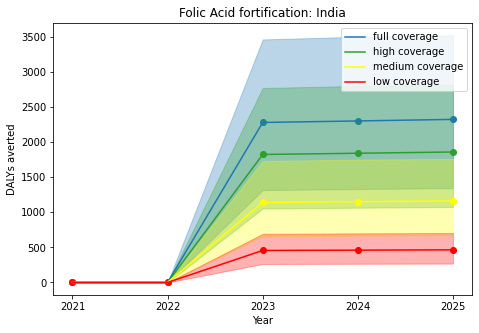

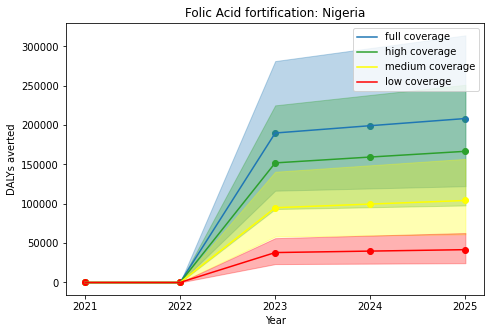

In [29]:
def plot_dalys_averted_by_country(save_path):
    pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
    location_names = {
        163:"India",
        214:"Nigeria",
        205:"Côte d'Ivoire",
        190:"Uganda",
        189:"United Republic of Tanzania"
    }
    colors = {'full': 'tab:blue', 'high': 'tab:green', 'medium':'yellow', 'low': 'red'}
    
    for loc in [163,214]:
        fig, ax = plt.subplots(figsize=(7.5, 5))
        for level in ['full', 'high','medium','low']:
            
            plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value, color = colors[level])
            plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value,  color = colors[level], label = f'{level} coverage')
            plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p90,
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p10, alpha=0.3, color = colors[level])
            plt.ylabel('DALYs averted')
            plt.xlabel('Year')
            plt.title(f'Folic Acid fortification: {location_names[loc]}')
            plt.legend()
            plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
        pdf.savefig(fig)
    
    plt.show()
    pdf.close()

save_path = '/ihme/homes/beatrixh/repos/scratch/test.pdf'    
plot_dalys_averted_by_country(save_path)


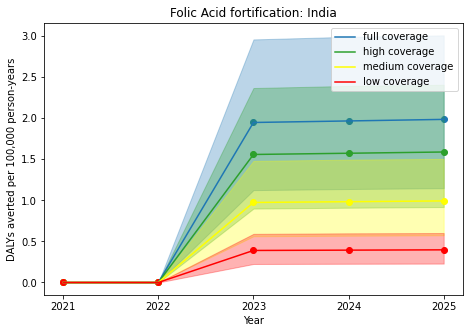

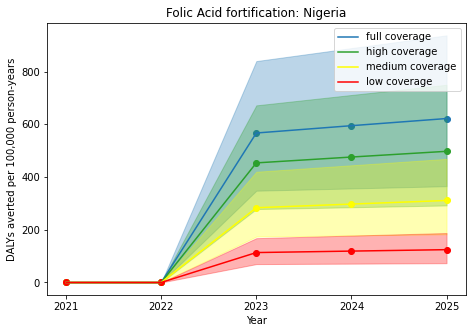

In [30]:
def plot_dalys_averted_per_100_000py_by_country(save_path):
    pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
    location_names = {
        163:"India",
        214:"Nigeria",
        205:"Côte d'Ivoire",
        190:"Uganda",
        189:"United Republic of Tanzania"
    }
    colors = {'full': 'tab:blue', 'high': 'tab:green', 'medium':'yellow', 'low': 'red'}
    
    for loc in [163,214]:
        fig, ax = plt.subplots(figsize=(7.5, 5))
        for level in ['full', 'high','medium','low']:
            
            plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py, color = colors[level])
            plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py,  color = colors[level], label = f'{level} coverage')
            plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p90_dalys_per_100_000py,
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p10_dalys_per_100_000py, alpha=0.3, color = colors[level])
            plt.ylabel('DALYs averted per 100,000 person-years')
            plt.xlabel('Year')
            plt.title(f'Folic Acid fortification: {location_names[loc]}')
            plt.legend()
            plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
        pdf.savefig(fig)
    
    plt.show()
    pdf.close()

save_path = '/ihme/homes/beatrixh/repos/scratch/test.pdf'    
plot_dalys_averted_per_100_000py_by_country(save_path)


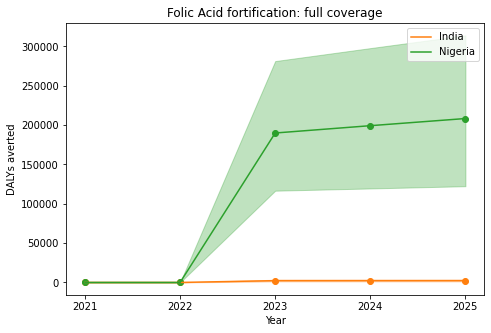

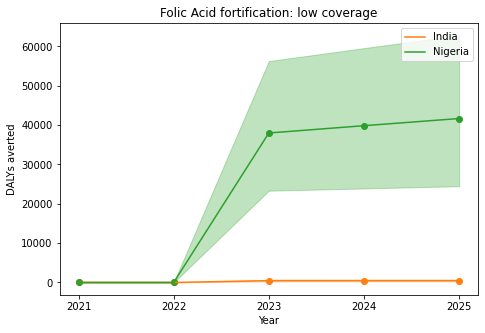

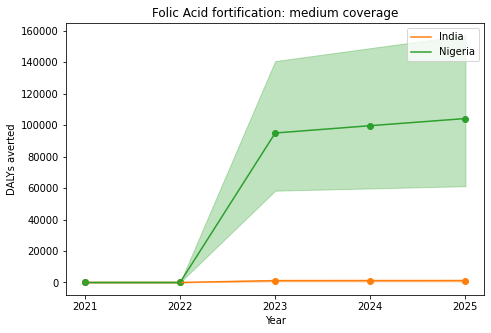

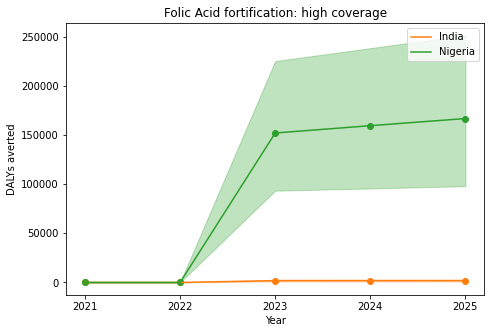

In [33]:
def plot_dalys_averted(save_path):
    pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
    location_names = {
        163:"India",
        214:"Nigeria",
        205:"Côte d'Ivoire",
        190:"Uganda",
        189:"United Republic of Tanzania"
    }
    colors = {190: 'tab:blue', 163: 'tab:orange', 214: 'tab:green', 205: 'yellow', 189:'purple'}

    for level in ['full', 'low', 'medium', 'high']:
        fig, ax = plt.subplots(figsize=(7.5, 5))
        for loc in [163,214]:
            
            plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value, color = colors[loc])
            plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value,  color = colors[loc], label = location_names[loc])
            plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p90,
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p10, alpha=0.3, color = colors[loc])
            plt.ylabel('DALYs averted')
            plt.xlabel('Year')
            plt.title(f'Folic Acid fortification: {level} coverage')
            plt.legend()
            plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
        pdf.savefig(fig)
    
    plt.show()
    pdf.close()

save_path = '/ihme/homes/beatrixh/repos/scratch/fa_dalys_averted_absolute.pdf'    
plot_dalys_averted(save_path)


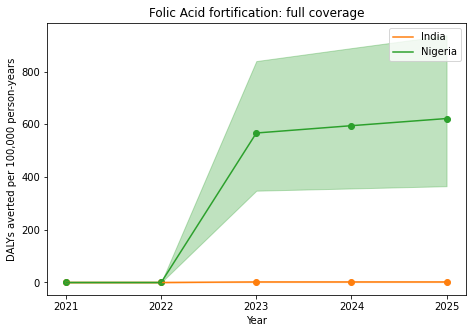

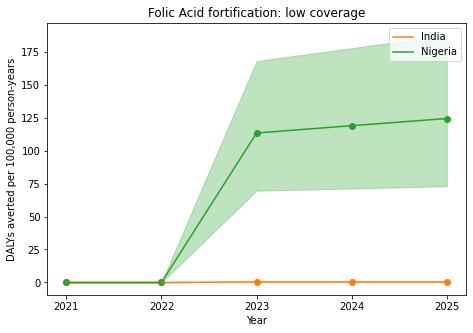

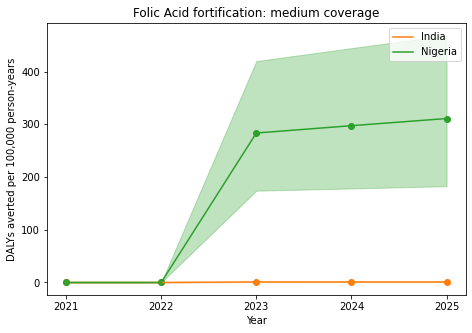

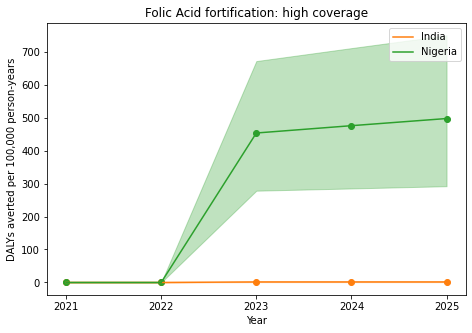

In [34]:
def plot_dalys_averted_rate(save_path):
    pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
    location_names = {
        163:"India",
        214:"Nigeria",
        205:"Côte d'Ivoire",
        190:"Uganda",
        189:"United Republic of Tanzania"
    }
    colors = {190: 'tab:blue', 163: 'tab:orange', 214: 'tab:green', 205: 'yellow', 189:'purple'}

    for level in ['full', 'low', 'medium', 'high']:
        fig, ax = plt.subplots(figsize=(7.5, 5))
        for loc in [163,214]:
    #     for loc in [163]:

            plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py, color = colors[loc])
            plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py,  color = colors[loc], label = location_names[loc])
            plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p90_dalys_per_100_000py,
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p10_dalys_per_100_000py, alpha=0.3, color = colors[loc])
            plt.ylabel('DALYs averted per 100,000 person-years')
            plt.xlabel('Year')
            plt.title(f'Folic Acid fortification: {level} coverage')
            plt.legend()
            plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
        pdf.savefig(fig)

    plt.show()
    pdf.close()

save_path = '/ihme/homes/beatrixh/repos/scratch/fa_dalys_averted_rate.pdf'    
plot_dalys_averted_rate(save_path)